<a href="https://colab.research.google.com/github/jarrodsb/DSPS_JBieber/blob/main/HW8/higgsbosonSearch_Bieber_dsps25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHYS 461 - Homework 8 - Jarrod Bieber

---



In [1]:
#imports
import pandas as pd
import numpy as np
import pylab as pl
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from pprint import pprint
from sklearn.metrics import confusion_matrix, roc_curve
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import RandomizedSearchCV

In [2]:
pip install kaggle

In [3]:
#mount your google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Remember tasks are not completed if you do not comment on the results and include captions

# Task 1 : data ingestion

- Download the Higgs boson data from Kaggle (programmatically within the notebook)

see how I did it in the Titanic Trees notebook https://github.com/fedhere/DSPS_FBianco/blob/main/CodeDemos/titanictree.ipynb

find the correct API link here https://www.kaggle.com/c/higgs-boson/data. The command is `!kaggle competitions download......` (you may need to agree to the terms of condition of the higgs boson challenge on the kaggle webpage)


In [4]:
# this gets to my drive folder
%cd gdrive/My\ Drive/

/content/gdrive/My Drive


In [5]:
# this makes sure the file is there: this cell should return "kaggle.json"
!ls kaggle.json

kaggle.json


In [6]:
# this limits who can view and make changes who can access this file.
!chmod 600 kaggle.json

In [7]:
# this reads in the file and stores it into the system variables of my colab sessions which allows me to connect programmatically to the kaggle platform
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [8]:
#check that it worked by listing the kaggle datasets
!kaggle datasets list

ref                                                             title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset    Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000          18268        620  1.0              
jaderz/hospital-beds-management                                 Hospital Beds Management                                47583  2025-10-03 09:21:58.590000          15389        357  1.0              
ahmadrazakashif/bmw-worldwide-sales-records-20102024            BMW Worldwide Sales Records (2010–2024)                853348  2025-09-20 14:39:45.280000          20318        396  1.0              
umutt

In [9]:
# i suggest you put the data in a folder inside of your dsps folder, which you should already have
%cd dsps

/content/gdrive/My Drive/dsps


In [10]:
!mkdir kaggleHiggsBosonSearch

mkdir: cannot create directory ‘kaggleHiggsBosonSearch’: File exists


In [11]:
!ls

kaggleHiggsBosonSearch	kaggleTitanic


In [12]:
%cd kaggleHiggsBosonSearch

/content/gdrive/My Drive/dsps/kaggleHiggsBosonSearch


In [13]:
!kaggle competitions download -c higgs-boson

higgs-boson.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
!ls

HiggsBosonCompetition_AMSMetric_rev1.py  random_submission.zip	training.csv
higgs-boson.zip				 test.zip		training.zip


In [15]:
!unzip higgs-boson.zip

Archive:  higgs-boson.zip
replace HiggsBosonCompetition_AMSMetric_rev1.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: random_submission.zip   
  inflating: test.zip                
  inflating: training.zip            


In [16]:
!ls

HiggsBosonCompetition_AMSMetric_rev1.py  random_submission.zip	training.csv
higgs-boson.zip				 test.zip		training.zip


In [17]:
!unzip training.zip

Archive:  training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training.csv            


In [18]:
!ls

HiggsBosonCompetition_AMSMetric_rev1.py  random_submission.zip	training.csv
higgs-boson.zip				 test.zip		training.zip


In [19]:
#use the training dataset and make your own trainng test set later
higgsdata = pd.read_csv("training.csv")

In this task, I configured my notebook to work with the Kaggle platoform using the kaggle.json file mounted onto my Google drive folder, similar to how it was done in the Titanic Trees notebook and in Homework 7. I then downloaded the Higgs zip file from Kaggle, and read it in as a DataFrame.

# Task 2: data exploration

In [20]:
higgsdata.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [21]:
higgsdata.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


do everything else you need to explore the data.... (I can think of 4 more things we have done together)

In [22]:
higgsdata.tail()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
249995,349995,-999.000,71.989,36.548,5.042,-999.0,-999.0,-999.0,1.392,5.042,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.0,-999.0,-999.0,2.585,22.439,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,-0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.0,-999.0,-999.0,2.390,22.183,...,1,41.992,1.8,-0.166,-999.0,-999.0,-999.0,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.0,-999.0,-999.0,3.365,13.504,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,1.681611,b
249999,349999,-999.000,72.756,70.831,7.479,-999.0,-999.0,-999.0,2.025,7.479,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,1.877474,b


In [23]:
higgsdata.shape

(250000, 33)

In [24]:
higgsdata.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

In [25]:
# Check if False everywhere ('0' = No missing values)
higgsdata.isna().sum().sum()

np.int64(0)

In [26]:
higgsdata.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

In [27]:
higgsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

In [28]:
correlation_matrix = higgsdata.corr(numeric_only=True)
display(correlation_matrix.head())

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
EventId,1.000000,0.001917,-0.006059,-0.001851,0.002073,-0.000060,0.000353,-0.000075,-0.001349,-0.000581,...,0.002312,0.000175,0.001396,0.001216,0.001214,-0.000065,-0.000068,-0.000060,0.001024,-0.002838
DER_mass_MMC,0.001917,1.000000,-0.455755,0.168548,0.198765,0.162661,0.160524,0.162521,0.228105,0.045826,...,0.221984,0.221078,0.250158,0.247083,0.247078,0.162836,0.162614,0.162609,0.185372,-0.327244
DER_mass_transverse_met_lep,-0.006059,-0.455755,1.000000,0.190109,-0.249116,-0.176386,-0.190392,-0.175942,0.043251,0.017758,...,-0.167811,-0.210537,-0.229674,-0.220370,-0.220355,-0.176837,-0.176231,-0.176225,-0.210009,0.419843
DER_mass_vis,-0.001851,0.168548,0.190109,1.000000,-0.062562,-0.032251,-0.040620,-0.032126,0.579712,-0.000702,...,0.053300,-0.026860,-0.019151,-0.013749,-0.013742,-0.033188,-0.032202,-0.032206,-0.052902,0.102172
DER_pt_h,0.002073,0.198765,-0.249116,-0.062562,1.000000,0.523664,0.534531,0.523639,-0.539379,0.310501,...,0.782547,0.623401,0.621599,0.564898,0.564894,0.531647,0.523714,0.523703,0.808616,-0.414084


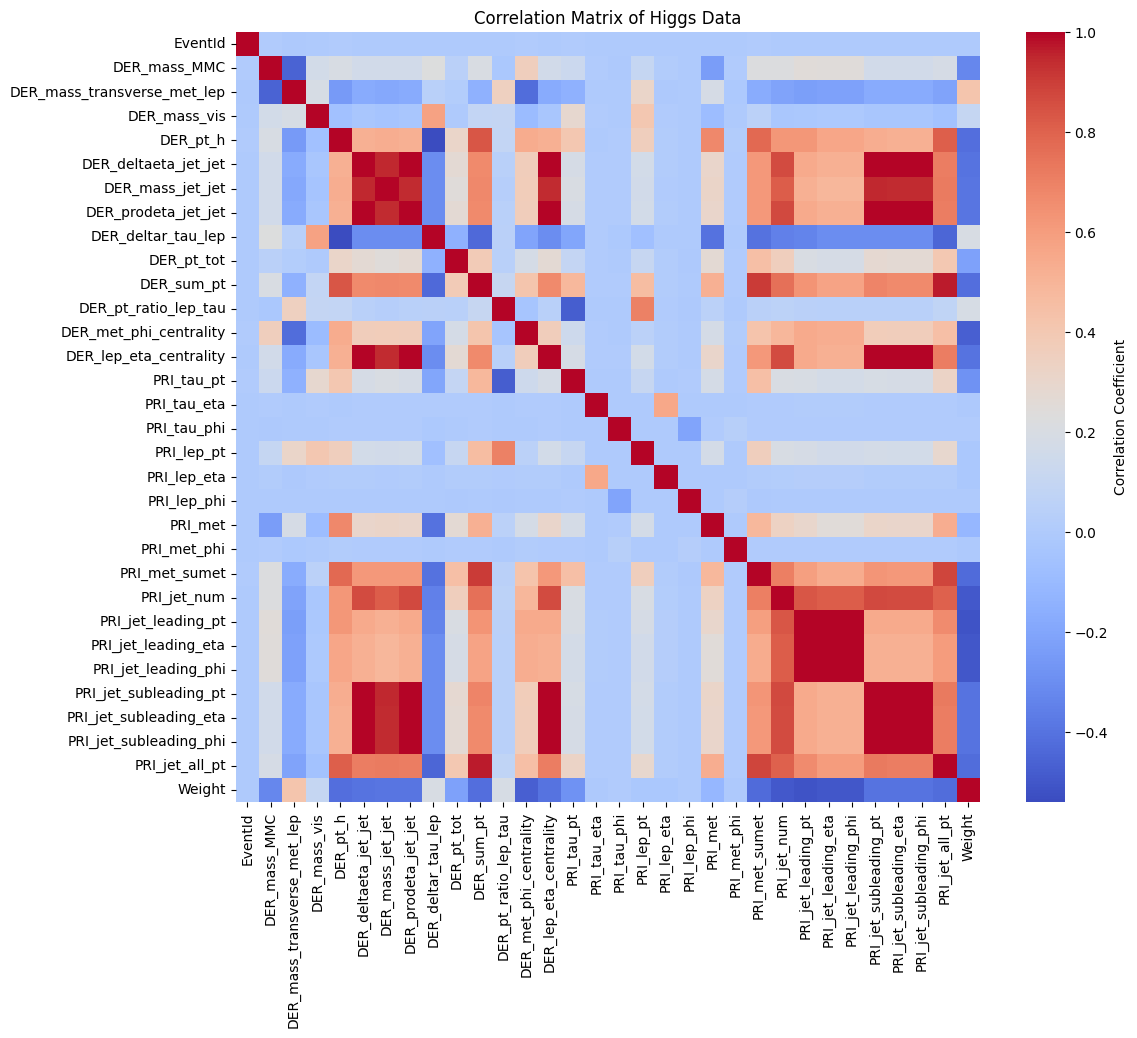

In [29]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Higgs Data')
plt.show()

Figure 1: A correlation matrix for comparing the numerical features in the Higgs dataset. The matrix was created using the .corr() method on the pandas DataFrame, which calculates the correlation of pairs of columns, excluding "EventId" "Label" and "Weight". The color map represents the strength and direction of the correlation, with redder colors indicating greater/positive correlation and bluer colors indicating lesser/negative correlation. Values close to zero suggest little to no correlation. Observing the color map, some features exhibit strong positive or negative correlations, which can potentially be important for understanding the relationships between different measurements and for potential feature selection in building the tree models.

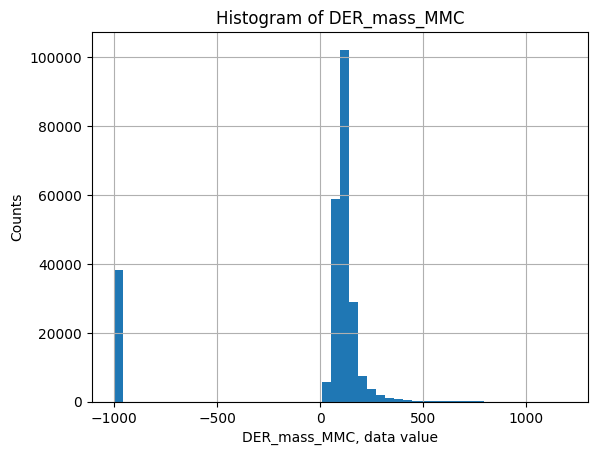

In [30]:
higgsdata['DER_mass_MMC'].hist(bins=50)
pl.xlabel('DER_mass_MMC, data value')
pl.ylabel('Counts')
pl.title('Histogram of DER_mass_MMC')
pl.show()

Figure 2: A histogram displaying the distribution of the (arbitrarilty chosen) "DER_mass_MMC" feature in the Higgs dataset, generated by plotting the frequency of values within 50 bins using the .hist() method on the variable column. There is a prominent peak at a relatively low mass value, along with a significant number of entries near -1000, indicating missing or invalid measurements for this feature. This suggests that the "DER_mass_MMC" calculation was not possible / invalid for a substantial portion of the data, which is important for subsequent data cleaning and feature handling.

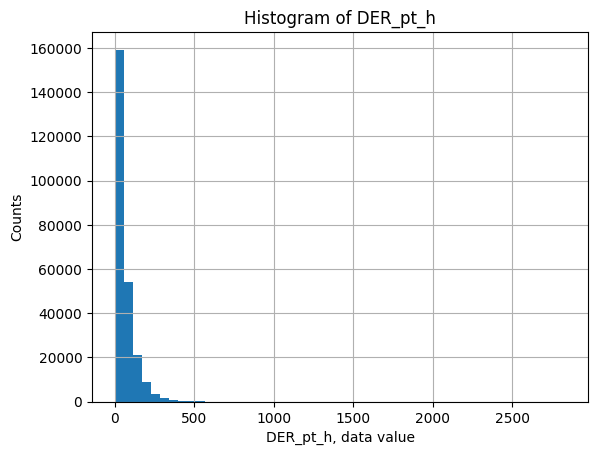

In [31]:
higgsdata['DER_pt_h'].hist(bins=50)
pl.xlabel('DER_pt_h, data value')
pl.ylabel('Counts')
pl.title('Histogram of DER_pt_h')
pl.show()

Figure 3: A histogram that shows the distribution of the (arbitrarilty chosen) "DER_pt_h" feature from the Higgs dataset, again created by plotting the frequency of values within 50 bins using the .hist() method on the variable column. The plot shows that the majority of events have relatively low momentum values, with a rapid decrease in occurances as the feature's value increases, and a tail extending towards higher values. This distribution suggests that while most Higgs candidates from collisions have fairly low transverse momentum, a smaller number of events show significantly higher values, which could indicate a different physical process taking place.

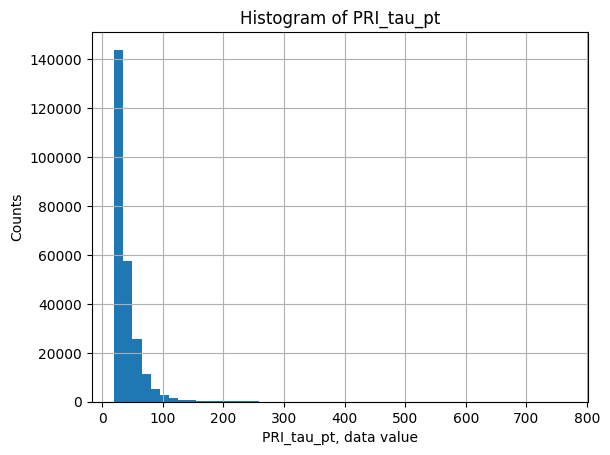

In [32]:
higgsdata['PRI_tau_pt'].hist(bins=50)
pl.xlabel('PRI_tau_pt, data value')
pl.ylabel('Counts')
pl.title('Histogram of PRI_tau_pt')
pl.show()

Figure 4: A histogram that shows the distribution of the (arbitrarily chosen) "PRI_tau_pt" feature in the Higgs dataset, created once again by plotting the frequency of values within 50 bins using the .hist() method on the variable column. The plot again demonstrates a strong concentration of events at lower values of the feature, with a steep decline in occurances as the momentum increases. This suggests that particles with low transverse momentum are much more commonly observed, while high-momentum tau particles are relatively rare.

In this task, I explored in various ways the Higgs DataFrame that I had created, including examing the shape of the data, the head and tail, looking at data types, checking for missing values, plotting a correlation matrix, as well as plotting histograms of a few randomly selected columns from the dataset, just to check that the values look like "real" science data.

# Task 3: data preparation


- Read in the training data. Extract the target variables. Split the provided training data into a training and a test set.

The last 2 columns are what you want to predict: "weight" and "label".
Remove them from the input data (along any other variable you should remove) and create a separate variable `labels` and a separate variable `weights`, which will be your target variables for, respectively, classification and regression.



 you will use two target variables (you can read more about the data at https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf): find the corresponding columns of the DF and save them as labels and weights respectively

In [33]:
training_data = higgsdata.drop(["EventId", "Weight", "Label"], axis=1)

In [34]:
# 's' stands for signal, 'b' for background. You want to find new particles, i.e. "signal"
labels = higgsdata["Label"]

In [35]:
# the weight of the particle
weights = higgsdata["Weight"]

use the "training.csv" file, but create your own train/test sets

In [36]:
train_x, test_x, train_y, test_y = train_test_split(training_data, labels, test_size=0.2, random_state=42)

In [37]:
train_regress_x, test_regress_x, train_regress_y, test_regress_y = train_test_split(training_data, weights, test_size=0.2, random_state=42)

In this task, I excluded from my dataset the values that we want to predict, and I defined training and testing data populations that will be used to check how well classification models can separate signal from the background (labels), as well as train and test data for evaluating a regression model to see how well it predicts the weight of particles in the dataset (weights). In both instances, the data was split 80% train and 20% test.

#Task 4: answer the question (you, not an AI...) why did I not ask you to scale the data like we did in the cluster models?

Data scaling is not necessary when using random forest and gradient boosted tree methods, because for these methods the distance between points doesn't matter (unlike for something like a K-Nearest distance metric). With tree methods, the data is split depending on the order that individual data points appear. This ordering is not affected by scaling.

# Task 5: tree-based classifications

Use a Random Forest and a Gradiend Boosted Tree Classifier model to predict the `label` of the particles, i.e. if a particle is `Signal` or `Background`. Get the score of each model on both the training and test set, compare the training and test results and comment on the result for each model (adjust the hyperparameters if you need to)


In [38]:
# Look at parameters used by our current forest
rf = RandomForestClassifier(random_state = 0)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [39]:
#now control some hyperparameters
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

In [40]:
gbt = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=0)

In [41]:
rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=10, random_state=0)

In [42]:
gbt.fit(train_x, train_y)

GradientBoostingClassifier(random_state=0)

In this section, I define an instance of a Random Forest and Gradient Boosted Tree classifier model, and then run a fit for both, using 100 trees each, and a max depth of 10 for Random Forest and 3 for Gradient Boost. A random state was set for reproducability. We will see the results of the fits in the next section.

# Task 6: model evaluation

calculate the  scores for the training and test sets and compare etc

In [43]:
print(f"the RF scores on the training test is {rf.score(train_x, train_y):.2f}, on the test is {rf.score(test_x, test_y):.2f}")
print("This indicates how well the Random Forest model performed on both the training and testing datasets. A significant difference between scores could indicate overfitting.")
print(f"the GBT scores on the training test is {gbt.score(train_x, train_y):.2f}, on the test is {gbt.score(test_x, test_y):.2f}")
print("This indicates how well the Gradient Boosted Tree model performed on both the training and testing datasets. A significant difference between scores could indicate overfitting.")

the RF scores on the training test is 0.84, on the test is 0.83
This indicates how well the Random Forest model performed on both the training and testing datasets. A significant difference between scores could indicate overfitting.
the GBT scores on the training test is 0.83, on the test is 0.83
This indicates how well the Gradient Boosted Tree model performed on both the training and testing datasets. A significant difference between scores could indicate overfitting.


**Comment** is your model performing well? is it .... overfitting?

The scores between training and test are very close for Random Forest, and are identical for Gradient Boosted. This says to me that the model is performing well and is ***not*** overfitting.

- Produce a confusion matrix for each model and compare them






In [44]:
# I creaded this function (mostly copied from sklearn examples).
# You can use it to create the confusion matrix, make sure you pass appropriate label

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='', labels=["P", "N"],
                          cmap=plt.cm.bone):
    """
    Plots a confusion matrix.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        normalize (bool, optional): If True, normalize the confusion matrix. Defaults to False.
        title (str, optional): Title of the plot. Defaults to ''.
        labels (list, optional): List of labels for the classes. Defaults to ["P", "N"].
        cmap (matplotlib.colors.Colormap, optional): Colormap for the plot. Defaults to plt.cm.bone.
    """
    if normalize:
          title = title + ' Normalized confusion matrix'
    else:
          title = title + ' Confusion matrix, without normalization'
    # Compute confusion matrix
    if normalize:
      cm = confusion_matrix(y_true, y_pred, normalize='all')
    else:
      cm = confusion_matrix(y_true, y_pred)
    # plot it
    fig, ax = plt.subplots(1, 1)
    fig.subplots_adjust()
    im = ax.imshow(np.rot90(cm), cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    # add an axes to the right of the main axes.
    plt.xticks([0, 1], labels=labels[::-1])

    plt.text(0,1, cm[0,0], ha='center', c="k" if cm[0,0] > 0.1 * cm.sum() else "w")
    plt.text(0,0, cm[0,1], ha='center', c="k" if cm[0,1] > 0.1 * cm.sum() else "w")
    # plt.text(1,1, cm[1,0], ha='center', c="k" if cm[1,0] > 0.1 * cm.sum() else "w")
    plt.text(1,1, cm[1,0], ha='center', c="w") # Force a white font in the top right quadrant
    plt.text(1,0, cm[1,1], ha='center', c="k" if cm[1,1] > 0.1 * cm.sum() else "w")
    plt.ylim(-0.5,1.5)
    plt.yticks([0,1], labels=labels)
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.title(title)
    cax = ax_divider.append_axes("right", size="10%", pad="2%")
    cb = plt.colorbar(im, cax=cax)

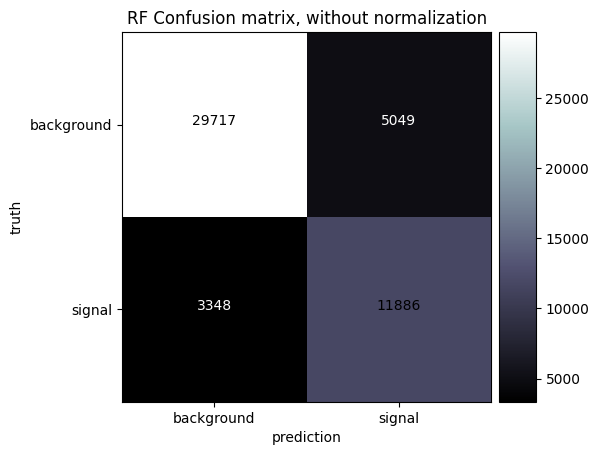

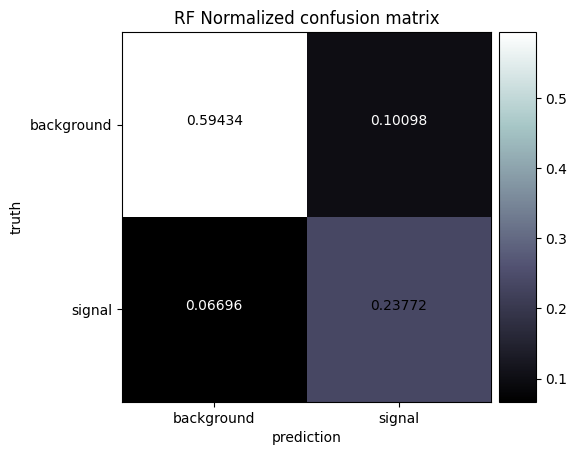

In [45]:
#for RF
plot_confusion_matrix(test_y, rf.predict(test_x), title="RF", labels=["signal", "background"])
plot_confusion_matrix(test_y, rf.predict(test_x), normalize=True, title="RF", labels=["signal", "background"])

Figure 5: A pair of confusion matrices for the Random Forest classifier on the test dataset. The upper matrix shows the raw counts of true positive, true negative, false positive, and false negative predictions, while the second is normalized, showing the proportion of each true class that was correctly or incorrectly classified. Both were generated using the provided function that takes the true and predicted labels as input. Observing these matrices provides a visualization of the model's performance. We see that our Random Forest model identifies more background events than signal events. While most of the signal is correctly identified, the raw counts matrix shows a significant number of false positives and negatives, suggesting there is room for improvement.

In [46]:
#do the same fo GBT, dont forget your captions!!

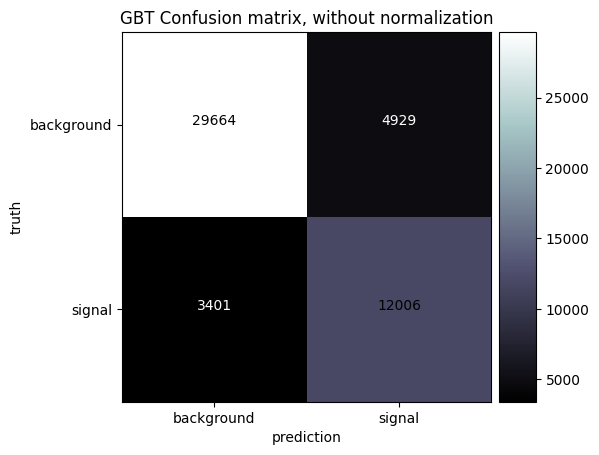

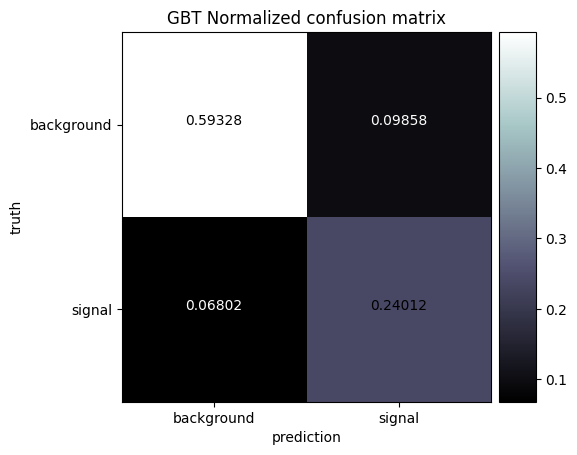

In [47]:
#for GBT
plot_confusion_matrix(test_y, gbt.predict(test_x), title="GBT", labels=["signal", "background"])
plot_confusion_matrix(test_y, gbt.predict(test_x), normalize=True, title="GBT", labels=["signal", "background"])

Figure 6: A pair of confusion matrices for the Gradient Boosted classifier on the test dataset. The upper matrix shows the raw counts of true positive, true negative, false positive, and false negative predictions, while the second is normalized, showing the proportion of each true class that was correctly or incorrectly classified. Both were generated using the provided function that takes the true and predicted labels as input. Observing these matrices provides a visualization of the model's performance. We see that our Gradient Boosted model also identifies more background events than signal events. From this confusion matrix, the GBT model appears to correctly identify a slightly larger proportion of true positive signals than the Random Forest model. Wheras the RF model identified a negligibly larger proportion of true negative signals.

Plot a simple ROC curve for the RF and GBT models and describe it in a caption.

In [48]:
#this will be passed to the ROC function
test_y.values.reshape(-1, 1).flatten() == "s"

array([False, False, False, ..., False, False, False])

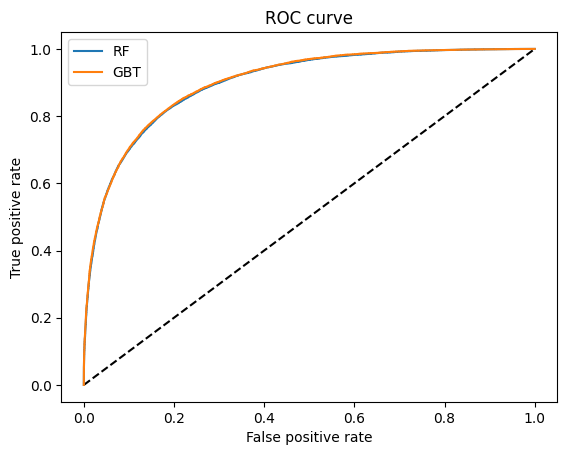

In [49]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.values.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.values.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


Figure 7: A plot depicting the Receiver Operating Characteristic (ROC) curves for both the Random Forest and Gradient Boosted Tree classifiers, made by plotting the True Positive Rate against the False Positive Rate at various thresholds. The diagonal dashed line represents the bare minimum performing classifier (basically a 50/50 coin flip), while curves above this line indicate better performance than random chance. The closer a curve is to the top-left corner, the more accurate the model is at selecting between signal and background. Both models in the plot perform significantly better than random, and their curves are very close, suggesting comparable classification ability on this dataset.

In this task, I evaluated the results of the fits of the RF and GBT models that were produced in Task 5, using three approaches. I looked directly at the classifier scores, produced confusion matrices, and finally produced an ROC curve. All evaluation methods indicate that the RF and GBT models perform quite similarly.

#Task 7 required for 661, EC for 461, tree-based regression


- Use a Random Forest and a Gradiend Boosted Tree Regressor model to predict the weight of the particles. Compare the model performance on training and test sets


In [50]:
rfR = RandomForestRegressor(max_depth=3, random_state=302)
rfR.fit(train_regress_x, train_regress_y)

RandomForestRegressor(max_depth=3, random_state=302)

In [51]:
gbtR = GradientBoostingRegressor(max_depth=3, random_state=302)
gbtR.fit(train_regress_x, train_regress_y)

GradientBoostingRegressor(random_state=302)

 Calculate the L2 and L1 loss functions for the fitted regression models (see slides for the definition) and discuss the results

In [52]:
def L1(y_true, y_pred):
  return np.mean(np.abs(y_true - y_pred))

def L2(y_true, y_pred):
  return np.mean((y_true - y_pred)**2)

In [53]:

print(f"L1 RF {L1(test_regress_y,  rfR.predict(test_regress_x)):.2f}, L2 RF {L2(test_regress_y, rfR.predict(test_regress_x)):.2f}")

L1 RF 1.00, L2 RF 1.83


In [54]:
print(f"L1 GBT {L1(test_regress_y,  gbtR.predict(test_regress_x)):.2f}, L2 GBT {L2(test_regress_y, gbtR.predict(test_regress_x)):.2f}")

L1 GBT 0.84, L2 GBT 1.36


**Discuss!**

The L1 and L2 loss values measure the performance of the Random Forest and Gradient Boosting Tree regression models in predicting the weights of the particles. The L1 loss (Mean Absolute Error) for the Random Forest model is 1.00, while for the Gradient Boosting Tree model, it is 0.84. The L2 loss (Mean Squared Error) for the Random Forest model is 1.83, and for the Gradient Boosting Tree model, it is 1.36. We see that the Gradient Boosting Tree model has lower L1 and L2 loss values than the Random Forest model on the test set. This suggests that the Gradient Boosting Tree model's predictions are closer on average to the true particle weights than the Random Forest model. Therefore, judging by the  the Gradient Boosting Tree regressor appears to be a slightly better model for predicting the particle weights in this dataset.

#Task 8: Choose between feature importance and grid optimization (due for both 461 and 661)







# Task 8a: feature importance
Use the "Titanic notebook" as a guide for the feature importance analysis  https://github.com/fedhere/DSPS_FBianco/blob/main/Labs/DSPS_2025_titanictree.ipynb

- For the Random Forest classifier, find the 4 most important features based on the simple unoptimized model you created earlier on. Use the documentation to find out what they are. We have not talked abotu the physics of this problem at all but the Kaggle challenge description should provide enogh information for you to comment on this result is somewhat superficially.

You can use ```rf.feature_importance_``` on the trained model to extract the relative importance of each feature (a number from 0 to 1) and then choose the features that have the 4 highest numbers (the numpy function ```argsort()``` is helpful here!)

(your features may looks slightly different than mine)

In [55]:
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)

In [56]:
best_features_index = sorted_indices[-4:]
best_features_index

array([13,  2,  1,  0])

In [57]:
higgsdata.drop(["EventId", "Label", "Weight"], axis=1).iloc[:, best_features_index[::-1]] #this sorts the data by feature

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,PRI_tau_pt
0,138.470,51.655,97.827,32.638
1,160.937,68.768,103.235,42.014
2,-999.000,162.172,125.953,32.154
3,143.905,81.417,80.943,22.647
4,175.864,16.915,134.805,28.209
...,...,...,...,...
249995,-999.000,71.989,36.548,24.754
249996,-999.000,58.179,68.083,23.416
249997,105.457,60.526,75.839,35.636
249998,94.951,19.362,68.812,27.944


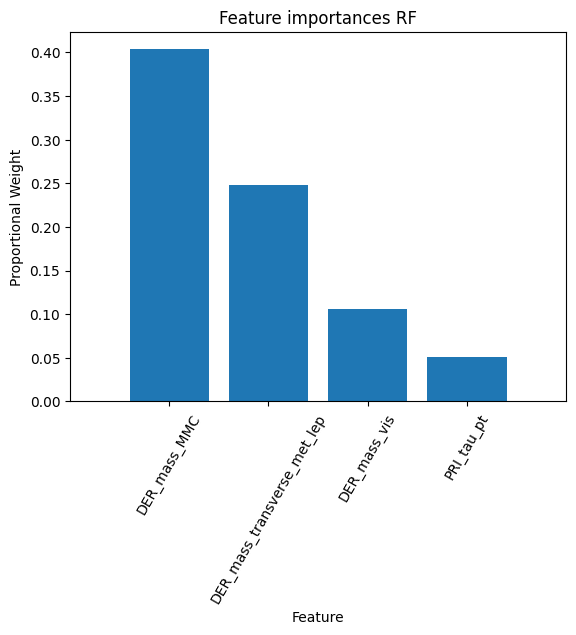

In [75]:
plt.figure()
plt.title("Feature importances RF")
plt.bar(range(len(best_features_index)), feature_importances[best_features_index[::-1]], align="center")
plt.xticks(range(len(best_features_index)), higgsdata.drop(["EventId", "Label", "Weight"], axis=1).iloc[:, best_features_index[::-1]].columns, rotation=60)
plt.xlim([-1, len(best_features_index)])
plt.xlabel("Feature")
plt.ylabel("Proportional Weight")
plt.show()

Figure 8: A bar chart that illustrates the relative contribution of the top four features in the Higgs dataset as determined by the Random Forest classifier. Created by extracting the "feature_importances_" attribute from the trained model, and selecting the highest four indices. The plot represents the magnitude of each feature's importance in the classification process. The x-axis labels correspond to the names of the features, obtained from the original dataframe's columns based on the identified important feature indices. The plot points to these four specific features in the Random Forest model as being the most influential in distinguishing between signal and background events, with DER_mass_MMC (a calculated mass based on the decay products of a given event/collision) being the #1 most influential. This suggests that it plays a significant role in the underlying physics of the Higgs experiment.

In [59]:
feature_importances = gbt.feature_importances_
sorted_indices = np.argsort(feature_importances)
best_features_index = sorted_indices[-4:]
best_features_index

array([13,  2,  1,  0])

In [60]:
higgsdata.drop(["EventId", "Label", "Weight"], axis=1).iloc[:, best_features_index[::-1]]

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,PRI_tau_pt
0,138.470,51.655,97.827,32.638
1,160.937,68.768,103.235,42.014
2,-999.000,162.172,125.953,32.154
3,143.905,81.417,80.943,22.647
4,175.864,16.915,134.805,28.209
...,...,...,...,...
249995,-999.000,71.989,36.548,24.754
249996,-999.000,58.179,68.083,23.416
249997,105.457,60.526,75.839,35.636
249998,94.951,19.362,68.812,27.944


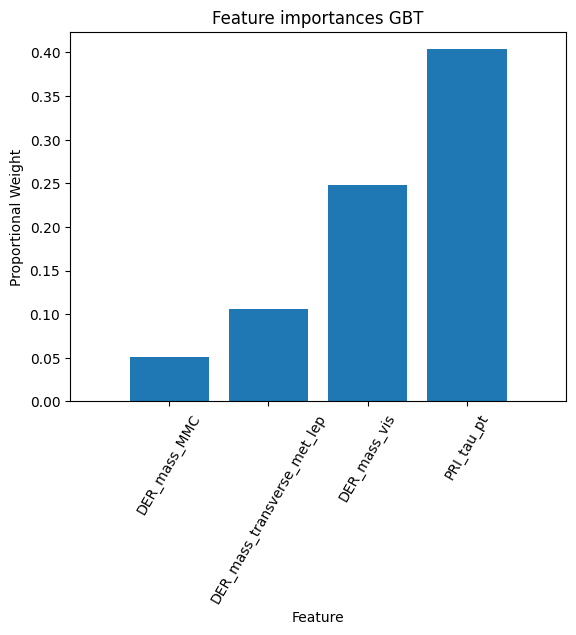

In [76]:
plt.figure()
plt.title("Feature importances GBT")
plt.bar(range(len(best_features_index)), feature_importances[best_features_index[::]], align="center")
plt.xticks(range(len(best_features_index)), higgsdata.drop(["EventId", "Label", "Weight"], axis=1).iloc[:, best_features_index[::-1]].columns, rotation=60)
plt.xlim([-1, len(best_features_index)])
plt.xlabel("Feature")
plt.ylabel("Proportional Weight")
plt.show()

Figure 9: A bar chart that visualizes the relative importance of the top four features in the Higgs dataset as determined by the Gradient Boosting Tree classifier. Created by extracting the "feature_importances_" attribute of the trained GBT model and selecting the highest four indices. The plot represents the magnitude of each feature's importance in the classification process. The x-axis labels correspond to the names of the features, obtained from the original dataframe's columns based on the identified important feature indices. The plot points to these four specific features in the Gradient Boosting Tree model as being the most influential in distinguishing between signal and background events, with PRI_tau_pt (transverse momentum of the tau particle  resulting from a collision) being the #1 most influential. This suggests that it plays a significant role in the underlying physics of the Higgs experiment.

In this task, I used the feature_importances attribute of the models to filter the top 4 most important features/columns in the Higgs dataset for each model, and displayed them as bar charts, showing their relative importances compared to other variables.

# Task 8b: hyperparameters grid search
- Explore the parameter space with the sklearn module ```sklearn.model_selection.RandomizedSearchCV``` *fitting only those 4 features*

Follow this example to set up the parameter search. Set the estimators to 10 and 100, (the number of trees) and the max depth to 3, and 10, and None (let it be unconstrained). Set bootstrap to both True and False. Set the number of features to consider at every split to both "autp" and "sqrt". Use ```pprint``` like I did earlier in this notebook to print the parameters set

**this takes some computational time! so do not start this at the last minute!!**

In [62]:
# choose your preferred values for the parameters you will test
random_grid = {'n_estimators': [10, 100, 300],
               'max_depth': [3, 10, None],
               'bootstrap': [True, False],
               'max_features': [None, "sqrt"]}

In [63]:
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [3, 10, None],
 'max_features': [None, 'sqrt'],
 'n_estimators': [10, 100, 300]}


 mine and your best features do not necessarily have to be the same because our models may be different (different parameters, different random seed etc)

In [64]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation,
# search across 18 different combinations
random_search = RandomizedSearchCV(estimator = rf, param_distributions=random_grid, n_iter=1, cv=3)


Note that this may take a long time! It took 1 hour for me to run this. Dont start at the last minute!!

In [65]:
random_search.fit(train_x[::5], train_y[::5])
# subselecting every 5th observation to reduce the computational time

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=10,
                                                    random_state=0),
                   n_iter=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 10, None],
                                        'max_features': [None, 'sqrt'],
                                        'n_estimators': [10, 100, 300]})

In [66]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=300,
                       random_state=0)

In [67]:
for k in random_search.best_params_:
  print(k,random_search.best_params_[k])

n_estimators 300
max_features sqrt
max_depth 10
bootstrap False


In [68]:
rf = RandomForestClassifier(**random_search.best_params_)
pprint(rf.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [69]:
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=300)

In [70]:
print("Tuned RF  Parameters: {}".format(random_search.best_params_))
print("Best score is {}".format(rf.score(test_x, test_y)))


Tuned RF  Parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Best score is 0.83268


In [71]:
df = pd.DataFrame(random_search.cv_results_) # this shows the result for the given parameters
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,56.574719,0.089746,0.399465,0.003852,300,sqrt,10,False,"{'n_estimators': 300, 'max_features': 'sqrt', ...",0.828259,0.826746,0.827496,0.8275,0.000618,1


Plot a simple  ROC curve for the RF model with the best parameters found in the previous step. Describe it. Compare it with the GBT model from before

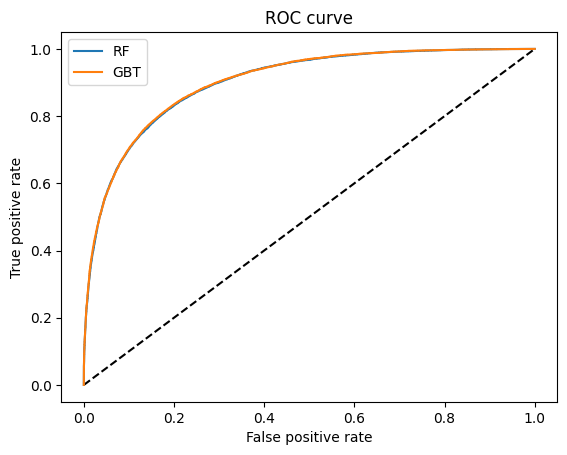

In [72]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.values.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.values.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Figure 10: A plot displaying the Receiver Operating Characteristic (ROC) curves for both the tuned Random Forest and the original Gradient Boosting Tree classifiers. The curves plots the True Positive Rate (TPR) against the False Positive Rate (FPR) for each model's predictions on the test set. They show that there is a trade-off between correctly identifying positive cases (signal) and incorrectly labeling negative cases (background). The dashed diagonal line represents a classifier that is essentially a random guess. Both the tuned Random Forest and the original Gradient Boosting Tree models exhibit ROC curves significantly above the random baseline. In this particular instance, the tuned RF model appears to again be performing very similarly to the GBT model. This suggests to me that the hyperparameter values that were selected from the grid search were indeed optimal, or at least good enough to match the GBT model performance.

In this task, I experimented with some different values of a few select hyperparameters/features for the RF model, then executed a random search to find the best values of the options I provided. I then fit the RF model with the optimized values, and compared the tuned model against the original GBT model in an ROC curve plot.